# Предсказание оптимальной температуры стали для следующей итерации

### Описание данных

- `data_arc.csv` — данные об электродах - способ нагрева ковша со сплавом. Данные о мощностях - активной и реактивной;
- `data_bulk.csv`, `data_bulk_time.csv` — данные о подаче сыпучих материалов (объём и время);
- `data_wire.csv`, `data_wire_time.csv` — данные о проволочных материалах (объём и время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;



## Содержание работы
1. <a href='#1'> Выдержки из EDA на основе которых собрана композиция модели </a> 
2. <a href='#2'> Варианты композиций МО для подхода к задаче, обучение, результаты </a>  
3. <a href='#3'> Общий вывод </a>  

In [60]:
#Импорты
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, cross_validate
from sklearn.dummy import DummyRegressor, DummyClassifier
from mpl_toolkits.mplot3d import Axes3D
from lightgbm import plot_importance
import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, classification_report, r2_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostRegressor
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet

from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

<a id='1'> </a>
### Тезисы из EDA

1. После 6 агвуста и до конца в имеющемся временном промежтке (до 1 сентября) значения температуры не регистрировались ни для одной из партий. Таким образом, было потеряно 739 ключей. Обучение, тест и валидация проводились на 2477 наблюдениях. 
1. Медианное время поиска оптимальной температуры партии -- 27 минут. Также были ваявлены партии, где время поиска равнялось 0. Они также были удалены из обучающего набора (не в качестве аномалий, а в качестве возможно не верно логированных данных). Также присутвуют партии, где время поиска оптимальной температуры достигает более двух часов -- они оставены в обучающем наборе, тк не оказывают явного влияния на целевой признак (график ниже, заметим, растянут по оси х, но внутри оси y находится как раз в средних диапазонах)

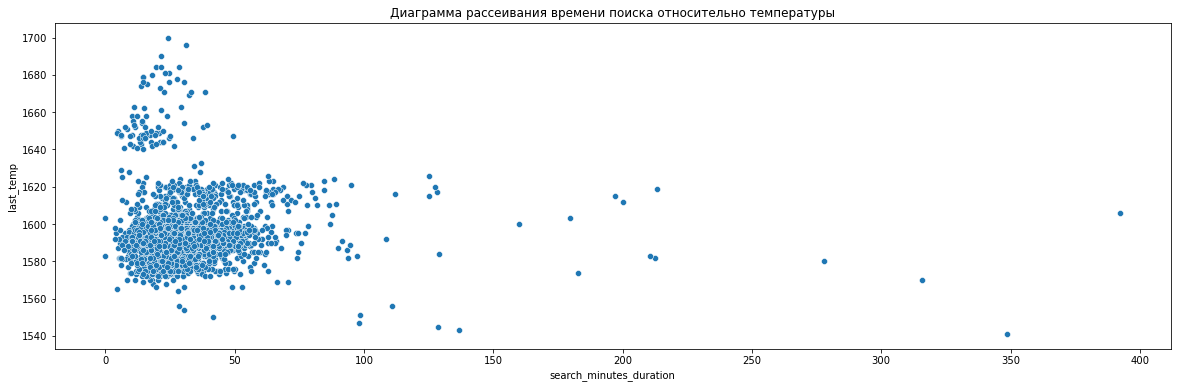

In [61]:
#Снятие температуры|
data_temp_raw = pd.read_csv(os.getcwd()+'/data_temp.csv', parse_dates=[1])
na_keys = data_temp_raw[data_temp_raw['Температура'].isna() == True]['key'].unique()

#Преобразование таблицы
data_temp = data_temp_raw.groupby('key').agg({'Температура':['first', 'last'],  'Время замера':['first', 'last']})

data_temp.columns = ['first_temp', 'last_temp', 'first_time', 'last_time']
data_temp = data_temp.query('index not in @na_keys')

#Счтаем время от начала до конца
data_temp['search_minutes_duration'] = round(pd.to_timedelta(data_temp['last_time'] - \
                                                       data_temp['first_time']).dt.seconds / 60, 2)

plt.figure(figsize=(20, 6))
sns.scatterplot(x=data_temp['search_minutes_duration'], y=data_temp['last_temp'])\
.set_title('Диаграмма рассеивания времени поиска относительно температуры')
plt.show()

#Срез нулевых минут
data_temp = data_temp.query('search_minutes_duration != 0') 

3. Рассмотрение структур временного ряда показывает, что  процесс похож на стационарный во времени (что подтверждается тестом Дики-Фуллера, pvalue == 0, следовательно мы можем отклонить гипотезу о нестационарности). Также на временном ряду заметен перерывм в работе предприятия (после 10 июля и до 17). Однако, мы не можем использовать в данной задаче признаки временного ряда, поскольку температура плавления зависит не только от паттернов техники, но и от физико-химических свойств стали. 

Вместе с этим из стационарности можно вынести, что температура относительно постоянна и держится в среднем диапазоне, кроме некоторых "аномалий".

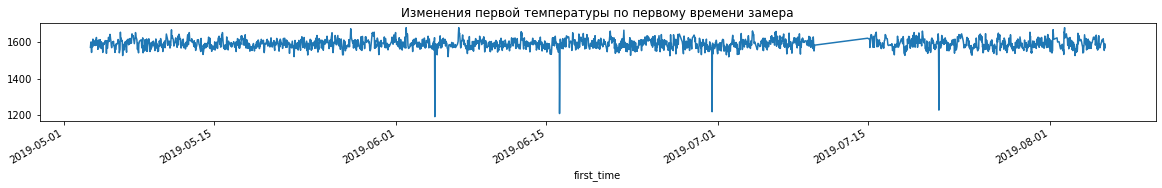

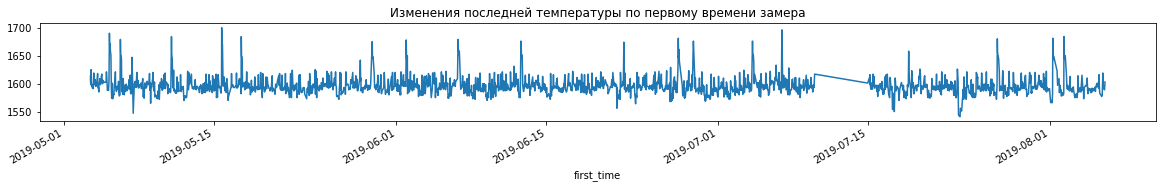

In [32]:
plt.figure(figsize=(20, 2))
data_temp.set_index('first_time')['first_temp'].plot()\
.set_title('Изменения первой температуры по первому времени замера');
plt.figure(figsize=(20, 2))
data_temp.set_index('first_time')['last_temp'].plot()\
.set_title('Изменения последней температуры по первому времени замера');

Text(0.5, 1.0, 'Изменения последней температуры по последнему времени замера')

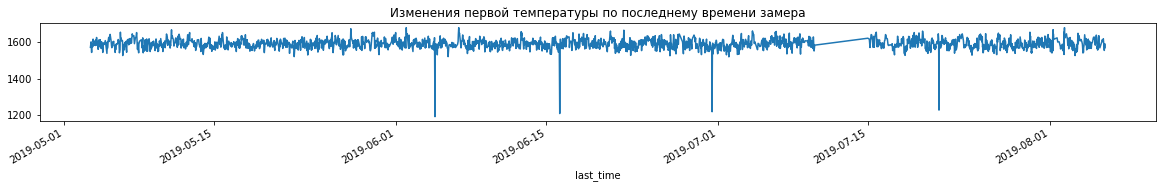

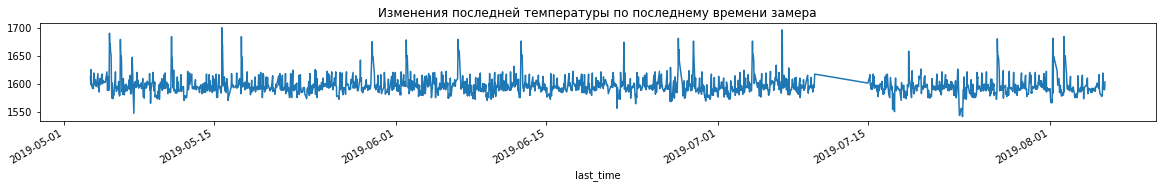

In [33]:
plt.figure(figsize=(20, 2))
data_temp.set_index('last_time')['first_temp'].plot()\
.set_title('Изменения первой температуры по последнему времени замера')
plt.figure(figsize=(20, 2))
data_temp.set_index('last_time')['last_temp'].plot()\
.set_title('Изменения последней температуры по последнему времени замера')

4. На основе пунтка 3 была выдвинута гипотеза: что если попробовать перед предсказанием температуры также предсказывать, будет ли новый объект аномалией? Результаты приведены в последнем пункте работы. 

Введенные классы: 0 -- для среднестатистических значений и 1 -- для выбивающихся. 

Распределение классов: 
 0    2280
1     195
Name: class, dtype: int64


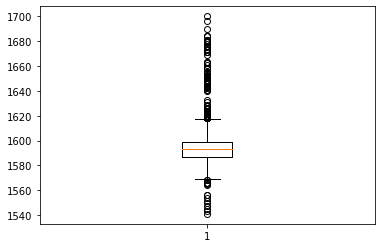

In [34]:
#Удалим лишние столбцы и заведем список ключей, чтобы позже соединить таблицы
data_temp = data_temp.drop(['first_time', 'last_time', 'search_minutes_duration'], axis=1)
current_keys = data_temp.index.unique()

#Запишем "выбросы" в отдельную переменную и дополним обучающий набор признаком класса -- 1 -- если аномалия 
#и 0 если среднестатистический объект выборки

outliers = plt.boxplot(data_temp['last_temp'])['fliers'][0].get_data()[1]

data_temp['class'] = data_temp['last_temp'].isin(outliers).astype('int')

print('Распределение классов:', '\n', data_temp['class'].value_counts())

#### Нагрев электродами 
1. Относительно временного ряда -- также похож на стохастический процесс (pvalue при Дики Фуллере == 0), следовательно мощность относительно постоянно и подается в определенных диапазонах. 
2. В один из дней был зарегестрирован выброс минусовой мощности. Однако данная аномалия становится невидимой после группировки таблицы -- в фичах  проекта использована только первая мощность. 

Здесь поясню:
я не считаю правильным использовать суммарную мощность, ибо количество итераций подачи различно от партии к партии и, когда к нам придет новый ковш мы не сможем знать, сколько раз и сколько суммарно мв подадим ему мощность.

Text(0.5, 1.0, 'Структура временного ряда активной мощности')

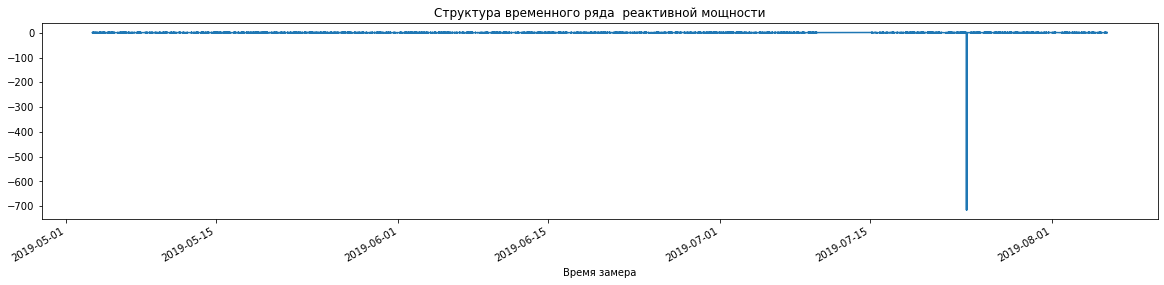

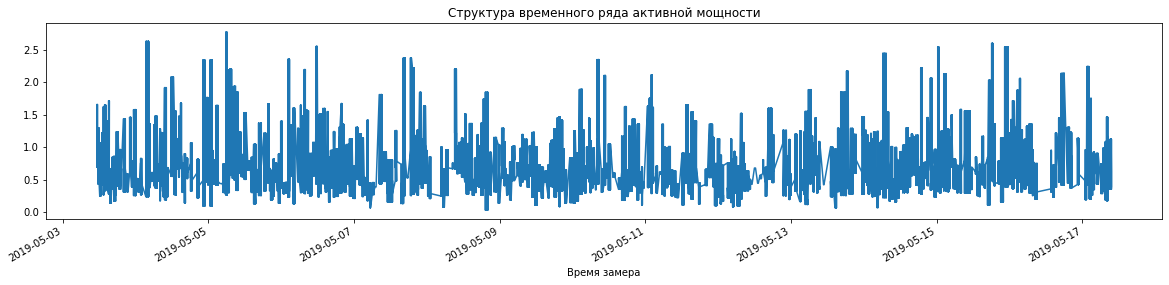

In [35]:
#Уберем ключи, для которых нет температуры 
data_arc_raw = pd.read_csv(os.getcwd()+'/data_arc.csv').set_index('key')

data_arc_raw = data_arc_raw.join(data_temp_raw.set_index('key')).query('index not in @na_keys')

plt.figure(figsize=(20, 4))
data_arc_raw.set_index('Время замера')['Реактивная мощность'][:100000].plot()\
.set_title('Структура временного ряда  реактивной мощности')
plt.figure(figsize=(20, 4))
data_arc_raw.set_index('Время замера')['Активная мощность'][:10000].plot()\
.set_title('Структура временного ряда активной мощности')

3. Для оптимизации учета метрик в модели для мощности были введены следующие признаки:

- Полная мощность:обозначение $S$, единица измерения: ВА (Вольт Ампер) $\sqrt{Q^2 + P^2}$ \
- Коэффициент мощности (Power Factor – PF): обозначение $k$ или $cosФ$ ($cosФ=k=P/S$), единица измерения: безразмерная величина

Внутри четырех признаков были рассмотрены и исключены мультиколлинерарные (с проверкой лучшего сочетания в модели). Можно было бы схлопнуть признаки через PCA, но я решила попробовать сохранить интерперетируемость. 

Text(0.5, 1.0, 'Корреляция метрик мощности между собой')

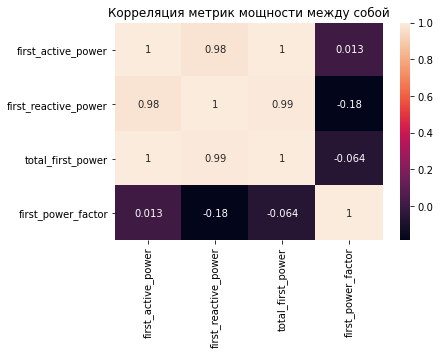

In [36]:
data_arc = data_arc_raw.query('key in @current_keys')
data_arc = data_arc_raw.groupby('key').agg({'Активная мощность' : ['first'],
                            'Реактивная мощность' : ['first']})

data_arc.columns = ['first_active_power', 'first_reactive_power']

#Рассчет признаков
data_arc['total_first_power'] = np.sqrt((data_arc['first_active_power']**2 + 
                                           data_arc['first_reactive_power']**2))
data_arc['first_power_factor'] = data_arc['first_active_power'] / data_arc['total_first_power']

sns.heatmap(data_arc.corr(), annot=True).set_title('Корреляция метрик мощности между собой')

In [37]:
#Постепенно начнем добавлять и анализировать признаки
full_data = data_arc.join(data_temp)

#Лучшие признаки
full_data = full_data.drop(['first_active_power', 'first_reactive_power'], axis=1)

#обновление списка ключей
current_keys = full_data.index

#### Этап подачи легирующих материалов

1. Исходя из двух таблиц было зарегестрировано, что некоторые материалы подаются реже других. 
Был протестирован подход перевода фичей, где пропусков более 70% в категориальные -- добавлялся материал или нет. Подход был оставлен. 

2. Также была добавлена фича о суммарном колчичестве bulks. 

In [38]:
#Легирующие материалы
data_bulk_raw = pd.read_csv(os.getcwd()+'/data_bulk.csv').set_index('key')
data_bulk_time = pd.read_csv(os.getcwd()+'/data_bulk_time.csv').set_index('key')

#Пропуски в таблицах совпадают, а значит когда материал не подавался не логгировалось его время

data_bulk_raw = data_bulk_raw.query('index in @current_keys')
data_bulk_raw['bulks_sum'] = np.sum(data_bulk_raw.iloc[:, :], axis=1)

#названия столбцов, где пропусков более 70%
more_70 = ['Bulk 1', 'Bulk 2', 'Bulk 5',
               'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13']

data_bulk_raw[more_70] = data_bulk_raw[more_70].apply(lambda x: (x.isna() == False).astype(int))
data_bulk_raw = data_bulk_raw.fillna(0)

#На всякий случай обновим список ключей
current_keys = data_bulk_raw.index

#### Этап подачи проволоки

1. Аналогично bulks, была рассчитана сумма добавленного материала. 
1. Материалы, где пропусков более 90% были переведены в категориальный признак. 
1. Wire 5 не удалось включить в признаки, ибо она не использовалась ни в одном из неудаленных ключей. 

In [39]:
#Проволочные материалы
data_wire = pd.read_csv(os.getcwd()+'/data_wire.csv').set_index('key')
data_wire_time = pd.read_csv(os.getcwd()+'/data_wire_time.csv')


data_wire = data_wire.query('key in @current_keys')

#Признаки с пропуском более 90%
more_90 = ['Wire 3', 'Wire 4', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'Wire 5']

data_wire[more_90] = data_wire[more_90].apply(lambda x: 
                            (x.isna() == False).astype(int))
#data_wire = data_wire.drop(['Wire 5'], axis=1)
data_wire = data_wire.fillna(0)

#На всякий случай снова обновим список ключей
current_keys = data_wire.index

#### Этап продувки газом  
1. График разброса, где по оси y разложен целевой признак, а по оси x -- объем газа, наблюдения c температурой более 1633 выбиваются из общего облака точек. Также, газ более 40 расширяет облако точек с данными значениями. 

Однако не совсем справедливо детектировать эти значения как выброс, без уточнения с технической стороны, кроме того, признак имеет "шарообразное" влияние на целевой (нет явной заивисомости). Данные значения оставлены, чтобы не урезать данные сильно.

In [40]:
 pd.read_csv(os.getcwd()+'/data_gas.csv').head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Text(0.5, 1.0, 'Диаграмма рассеяния поданного газа по последней температуре')

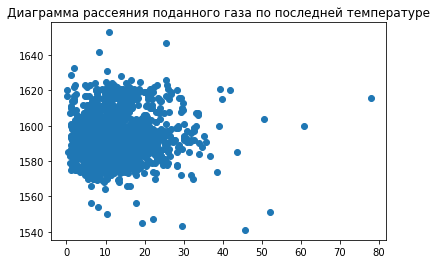

In [41]:
#Продувка газом
data_gas = pd.read_csv(os.getcwd()+'/data_gas.csv')
#data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

data_gas = data_gas.query('key in @current_keys').set_index('key').dropna()

current_keys = data_gas.index

plt.scatter(x=data_gas['Газ 1'], y=full_data.query('index in @current_keys')['last_temp'])
plt.title('Диаграмма рассеяния поданного газа по последней температуре')

<a id='2'> </a>
## Варианты композиций МО для подхода к задче

Финально перед обучением у нас вышло 2329 наблюдей, описанных 29ю признаками. Категрианльыне признаки сохранены в переменных `more_90` и `more_70`.

In [42]:
# Итого: соединим таблицы 

full_data = full_data.query('index in @current_keys')
data_bulk = data_bulk_raw.query('index in @current_keys')
data_wire = data_wire.query('index in @current_keys')

full_data = full_data.join([data_bulk_raw, data_wire, data_gas])

display(full_data.head())
print('Размерность данных:', full_data.shape)
print('Наличие дубликатов:', full_data.duplicated().sum())
#print('Наличие пропусков:', full_data.isna().sum()) #пропусков нет ни в одном столбце

,total_first_power,first_power_factor,first_temp,last_temp,class,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
key,,,,,,,,,,,,,,,,,,,,,
1,1.193639,0.817717,1571.0,1613.0,0.0,0,0,0.0,43.0,0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,0.521549,0.839928,1581.0,1602.0,0.0,0,0,0.0,73.0,0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,1.256527,0.845229,1596.0,1599.0,0.0,0,0,0.0,34.0,0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
4,1.069423,0.818491,1601.0,1625.0,1.0,0,0,0.0,81.0,0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
5,1.174466,0.808900,1576.0,1602.0,0.0,0,0,0.0,78.0,0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


Размерность данных: (2329, 31)
Наличие дубликатов: 0


In [43]:
#Слеплены категориальные и нет признаки, чтобы было удобно нормализовывать. 
cat_features = more_90 + more_70
dont_cat_features = ['total_first_power', 'first_power_factor', 'first_temp',
       'Bulk 3', 'Bulk 4','Bulk 6', 'Bulk 12', 'Bulk 14',
       'Bulk 15', 'bulks_sum', 'Wire 1', 'Wire 2', 'Газ 1']

print(cat_features)

['Wire 3', 'Wire 4', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'Wire 5', 'Bulk 1', 'Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13']


Ниже приведена визуализация потенциальных классов в общем облаке точек. 

/Users/sad__sabrina/opt/anaconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:763: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/Users/sad__sabrina/opt/anaconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:765: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


Text(0.5, 0.92, 'Проекция наблюдений с заданными классами')

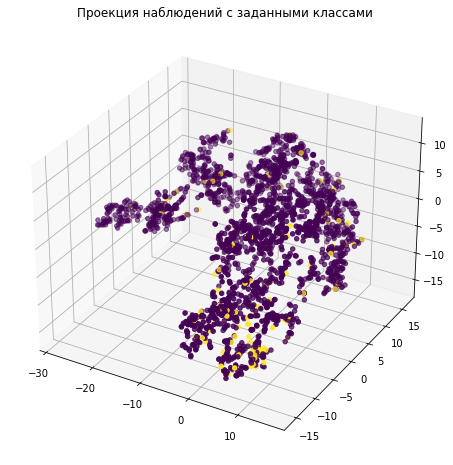

In [44]:
full_scaler = StandardScaler()

tsne = TSNE(n_components=3, random_state=0)
projections = tsne.fit_transform(full_data.drop(['last_temp', 'class'], axis=1))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(projections[:, 0], projections[:, 1], projections[:, 2], zdir=projections[:, 0],
           c=full_data['class'])
plt.title('Проекция наблюдений с заданными классами')

Классы внутри облака имеют скорее хаотичное, нежели паттерное расположение в общем облаке точек. Как мы увидим ниже, это скажется на работе алгоритмов в обычной композиции -- на всём возможном распределении целевого признака средняя ошибка ~ равна 7, тогда как на том, что в границе доверительных интервалов ~ 5.

В связи с этим был опробован подход композиции из двух задач: сначала классифицировать новый объект на предмет того, будет ли он аномальным или нет, а после подавать матрицу признаков регрессионному алгоритму. Такой подход позволяет охватывать весь диапазон признака, имея ошибку примерно равную 5,5. При этом для предсказания нам нужны только признаки первой итерации. 

Конечно, такая композиция нуждается в дообучении на данных, поскольку модель обучалась в ситуации дисбаланса классов. Однако улучшение качества показатель, что композиционная идея может быть доработана и может улучшить производственный процесс.

### Обучение и результаты

Внутри обычной композиции на диапазоне как полного, так и усеченного признаков наилучшим образом себя показал LGBMRegressor. Обучение и анализ признаков ниже

In [45]:
cv = KFold(n_splits=3, random_state=7, shuffle=True)

def get_cv_scores(estimator, x_train, y_train, cv, x_test, y_test):
    """
    estimator: sklearn estimator class,
    x(y)_train: train features and train_target,
    cv: crocc validation object,
    x(y)_test: test features and test target
    
    Function show cross_val scores (scoring MAE, MSE, R2) ang test MAE
    return: fitted estimator"""
    
    cv_data = pd.DataFrame(cross_validate(RandomForestRegressor(), x_train, y_train, cv=3,
               scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']))
    estimator = estimator.fit(x_train, y_train)
    test_mae = mean_absolute_error(y_test, estimator.predict(x_test))
    
    print(f'Estimator: {estimator}')
    print('Estimator cross_val_scores:')
    display(cv_data)
    print('Test MAE:', test_mae )
    
    return estimator  

def get_train_test(x, y,  dont_cat_features, scaler):
    """
    x: train features, pandas DataFrame
    y: train target, pandas Series
    dont_cat_fetures: list of col names
    scaler: sklearn transformer
    
    return train and test samples with transformed numeric features (test size = 25%) """
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
    
    transformer = scaler.fit(x_train[dont_cat_features])
    train_transformed = pd.DataFrame(transformer.transform(x_train[dont_cat_features]), 
                                                     columns=dont_cat_features,
                                              index=x_train.index)
    test_transformed = pd.DataFrame(transformer.transform(x_test[dont_cat_features]), columns=dont_cat_features,
                                 index=x_test.index)
    x_train_trans = train_transformed.join(x_train.drop([i for i in dont_cat_features], axis=1))
    x_test_trans = test_transformed.join(x_test.drop([i for i in dont_cat_features], axis=1))
    
    return x_train_trans, x_test_trans, y_train, y_test

In [46]:
x_full = full_data.drop(['last_temp', 'class'], axis=1)
y_full = full_data['last_temp']

x_train_full, x_test_full, y_train_full, y_test_full = get_train_test(x_full, y_full,
                                                        dont_cat_features, StandardScaler())

# Выборки обучения в границе ДИ (0.01-0.98)

part_data = full_data.query('last_temp > 1572 and last_temp < 1614')

x_part = part_data.drop(['last_temp', 'class'], axis=1)
y_part = part_data['last_temp']

x_train_part, x_test_part, y_train_part, y_test_part = get_train_test(x_part, y_part,
                                                        dont_cat_features, StandardScaler())

**LightGBMRegressor on part data**

Estimator: LGBMRegressor(min_child_samples=200)
Estimator cross_val_scores:


,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_r2
0,0.676928,0.015509,-5.778684,-54.350257,0.203830
1,0.669447,0.015361,-5.810620,-54.445732,0.209123
2,0.724355,0.015002,-5.722787,-54.294012,0.146595


Test MAE: 5.438738325033069


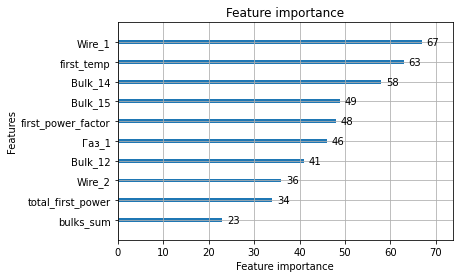

In [47]:
part_lgbm = get_cv_scores(LGBMRegressor(boosting_type='gbdt', learning_rate=0.1, min_child_samples=200),
              x_train_part, y_train_part, cv, x_test_part, y_test_part)

plot_importance(part_lgbm, max_num_features=10);

In [48]:
part_dummy = get_cv_scores(DummyRegressor(), 
            x_train_part, y_train_part, cv, x_test_part, y_test_part)
#только с важными признаками метрика осталась статична

Estimator: DummyRegressor()
Estimator cross_val_scores:


,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_r2
0,0.714429,0.017324,-5.723590,-53.151845,0.221385
1,0.671710,0.015017,-5.781917,-53.974608,0.215967
2,0.685881,0.014851,-5.671055,-52.973854,0.167346


Test MAE: 6.014136045442762


На частичном датасете нам удается снизить среднюю абсолютную ошибку с 16 относительно первого и последнего замера (рассчитано на сырых данных) до 5.7. Относительно улучшения процесса -- это значит, что модель позволяет нам уменьшать ошибку на 11 пунктов. 

Однако при таком улучшении мы работаем в урезанном диапазоне (не учитываем немного чуть более низких и  высоких температур). Также r2 показывает, что мы объясняем изменение целевой переменной моделью в текующей конфигурации примерно на 20% и относительно ситуации, если бы мы всегда предсказывали среднее наше улучшение всего лишь 0.6-7 пункта (хотя, справедливости ради, мы базируемся на признаках). 

Text(0.5, 1.0, 'Аппроксимация предсказаний на частичных данных')

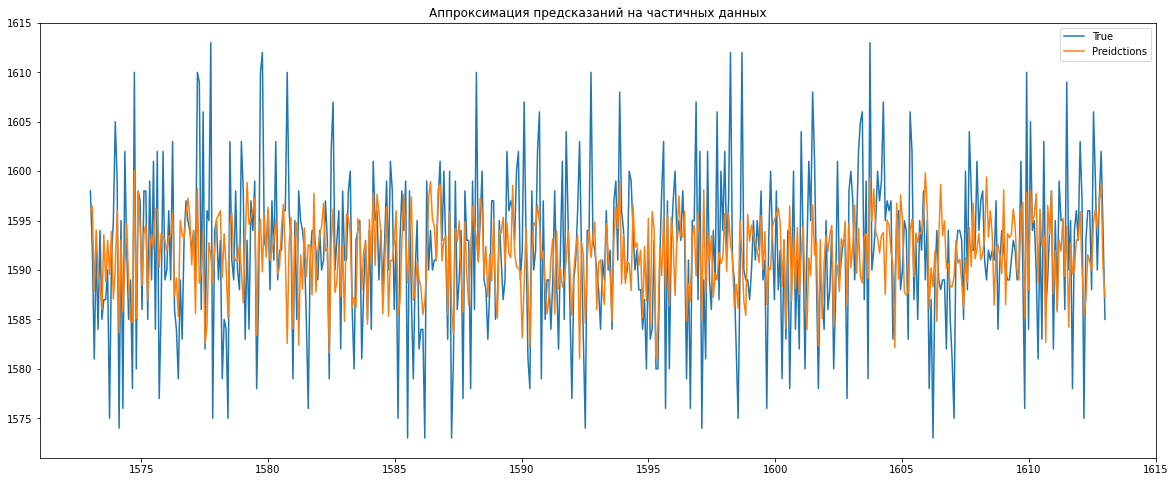

In [49]:
part_predictions = part_lgbm.predict(x_test_part)

plt.figure(figsize=(20, 8))
plt.plot(np.linspace(y_test_part.min(), y_test_part.max(), 532), y_test_part, label='True')
plt.plot(np.linspace(y_test_part.min(), y_test_part.max(), 532), part_predictions, label='Preidctions')
plt.legend()
plt.title('Аппроксимация предсказаний на частичных данных')

График также наглядно показывает, что мы хорошо аппроксимируем средние значения, но не достаточно огибаем пиковые. 

**LightGBMRegressor on full data**

Estimator: LGBMRegressor(importance_type='gain', min_child_samples=1)
Estimator cross_val_scores:


,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_r2
0,0.778843,0.014665,-7.256546,-93.197219,0.284005
1,0.796807,0.027846,-7.070378,-88.438810,0.200940
2,1.078346,0.023694,-7.163454,-89.846308,0.312697


Test MAE: 7.403713559346253


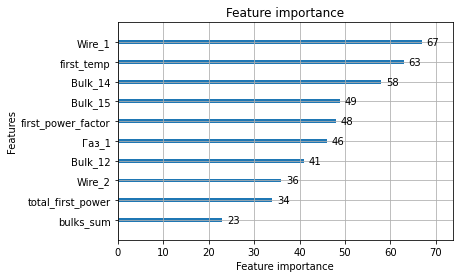

In [50]:
full_lgbm = get_cv_scores(LGBMRegressor(boosting_type='gbdt', learning_rate=0.1, min_child_samples=1, 
                           importance_type='gain'),
              x_train_full, y_train_full, cv, x_test_full, y_test_full)

plot_importance(part_lgbm, max_num_features=10);

In [51]:
full_dummy = get_cv_scores(DummyRegressor(),
        x_train_full, y_train_full, cv, x_test_full, y_test_full)

Estimator: DummyRegressor()
Estimator cross_val_scores:


,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_r2
0,0.750612,0.015270,-7.187062,-92.845944,0.286704
1,0.687509,0.014826,-7.134124,-90.688302,0.180615
2,0.687840,0.014990,-7.181718,-92.551988,0.291999


Test MAE: 8.038434333610365


На полных данных мы улучшаем показатели лишь на 9 пунктов. Однако, при этом нам удается лучше охватить зависимость (метрика r2). 

Но мы все еще не сильно выигрываем у базовой модели. 

Text(0.5, 1.0, 'Аппроксимация предсказаний на полных данных')

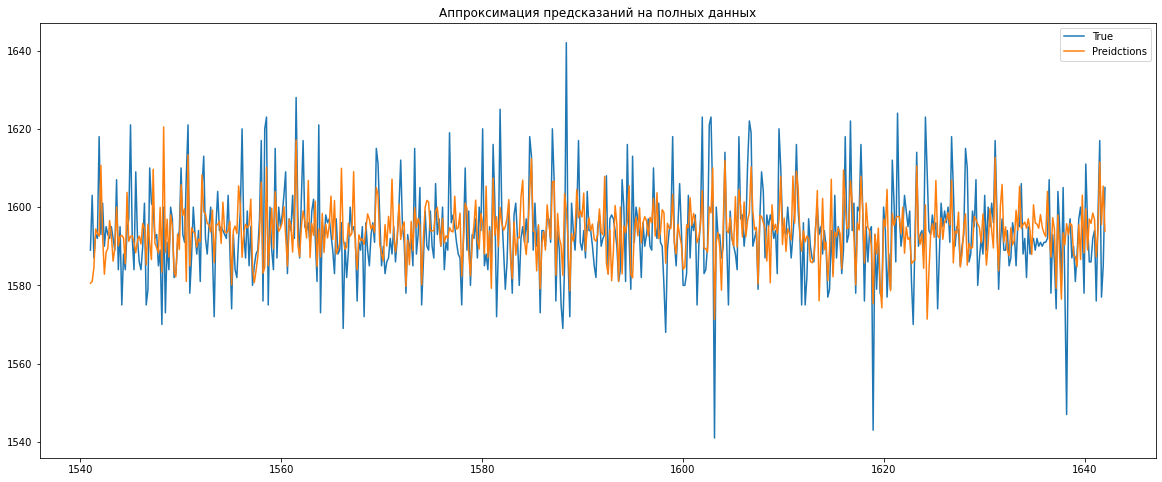

In [52]:
full_predictions = full_lgbm.predict(x_test_full)

plt.figure(figsize=(20, 8))
plt.plot(np.linspace(y_test_full.min(), y_test_full.max(), 583), y_test_full, label='True')
plt.plot(np.linspace(y_test_full.min(), y_test_full.max(), 583), full_predictions, label='Preidctions')
plt.legend()
plt.title('Аппроксимация предсказаний на полных данных')

Картина аппроксимации на полных данных показывает, что мы более широко охватываем выбивающиеся значения, однако продолжаем не дотягивать. Рассмотрим третий сценарий. 

**Bagging composition RandomForest + CatBoost**

Идея: попробуем уловить паттерн выбивающихся значений. Для этого обучающему набору присвоим метки, где 1 -- значение, выбивающееся из статистичекого диапазона и 0 -- значение, находящееся в его рамках. 

В первую итерацию будем подавать на вход модели объекты на классификацию, далее -- объект с присвоенным классом - регрессору. 

Обучение проводим так: классификатор учиться на данных без целевого признака. В качестве таргета class. Регрессор учится на данных с классом, в качестве таргета -- температура. В качестве тестовой выборки задача классификатора присвоить класс, а регрессора -- с присвоенным классификатором классом -- значение температуры. 

Перед обучением делаем небольшой ресемпл, уменьшая количество обхектов серединного класса и чуть повышая колчиество объектов выбивающегося, чтобы избежать оверфита. 

In [53]:
full_data['class'] = full_data['class'].astype('int')
print('Текущие классы', '\n', full_data['class'].value_counts())

#Сделаем ресемпл классов перед обучением 
df0 = full_data[full_data['class'] == 0].sample(1800, random_state=17)
df1 = full_data[full_data['class'] == 1].sample(150, replace=True, random_state=17)
test = pd.concat([df0, df1], ignore_index=True)

Текущие классы 
 0    2216
1     113
Name: class, dtype: int64


In [96]:
warnings.filterwarnings('ignore')

x_full_bag = test.drop(['last_temp', 'class'], axis=1)
y_full_bag = test['class']


x_train_full_bag, x_test_full_bag, y_train_full_bag, y_test_full_bag = train_test_split(x_full_bag, 
                                         y_full_bag, test_size=0.25, stratify=y_full_bag, random_state=27,
                                                                                       shuffle=True)

rf_bag = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                                random_state=27).fit(x_train_full_bag, y_train_full_bag)
dummy_class = DummyClassifier().fit(x_train_full_bag, y_train_full_bag)

print('Model', '\n', classification_report(y_test_full_bag, rf_bag.predict(x_test_full_bag)))
print('Dummy', '\n', classification_report(y_test_full_bag, dummy_class.predict(x_test_full_bag)))

x_train_full_bag.loc[:, 'class'] = y_train_full_bag
x_test_full_bag.loc[:, 'class'] = rf_bag.predict(x_test_full_bag)

y_train_full_bag2 = test['last_temp'][y_train_full_bag.index]
y_test_full_bag2 = test['last_temp'][y_test_full_bag.index]

cat_bag2 = CatBoostRegressor(loss_function='MAE', random_state=27, verbose=0).fit(x_train_full_bag,
                                                                                 y_train_full_bag2)


dummy_reg = DummyRegressor().fit(x_train_full_bag, y_train_full_bag2)

print('Model MAE:', mean_absolute_error(y_test_full_bag2, cat_bag2.predict(x_test_full_bag)))
print('Dummy MAE:', mean_absolute_error(y_test_full_bag2, dummy_reg.predict(x_test_full_bag)))

Model 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       450
           1       0.97      0.74      0.84        38

    accuracy                           0.98       488
   macro avg       0.97      0.87      0.91       488
weighted avg       0.98      0.98      0.98       488

Dummy 
               precision    recall  f1-score   support

           0       0.92      0.91      0.91       450
           1       0.07      0.08      0.07        38

    accuracy                           0.84       488
   macro avg       0.49      0.49      0.49       488
weighted avg       0.85      0.84      0.85       488

Model MAE: 5.9521062080117675
Dummy MAE: 8.590001345563014


In [55]:
#ещё важно: оценим коэффициент детерминации:
print(' Коэффициент детерминации:', r2_score(y_test_full_bag2, cat_bag2.predict(x_test_full_bag)))
print(' Коэффициент детерминации (dummy):', r2_score(y_test_full_bag2, dummy_reg.predict(x_test_full_bag)))

 Коэффициент детерминации: 0.5241728933932557
 Коэффициент детерминации (dummy): -0.001091039869067778


Имеем:

Композиционный алгоритм имеет точность чуть менее худшую, чем алгоритм, работающий на части данных. Однако, при этом, его комбинация признаков пощволяет нам поднять долю объясняемой дисперсии на 30%. Конечно, данный подход некорректно выставлять в продакшен на текущем этапе, однако результаты доказывают, что метод бэггинга позволит оптимизировать затраты на итерации поиска оптимальной температуры и не потерять при этом в аппроксимации целевого признака. 

Text(0.5, 1.0, 'Аппроксимация предсказаний на полных данных при помощи композиции')

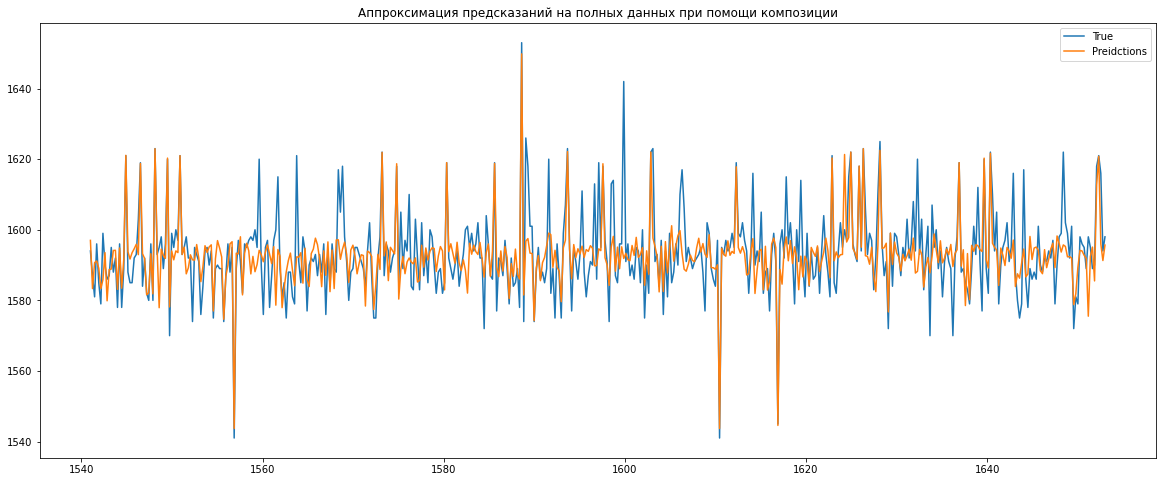

In [56]:
bag_predictions =  cat_bag2.predict(x_test_full_bag)

plt.figure(figsize=(20, 8))
plt.plot(np.linspace(y_test_full_bag2.min(), y_test_full_bag2.max(), 488), y_test_full_bag2, label='True')
plt.plot(np.linspace(y_test_full_bag2.min(), y_test_full_bag2.max(), 488), bag_predictions, label='Preidctions')
plt.legend()
plt.title('Аппроксимация предсказаний на полных данных при помощи композиции')

Визуализация предсказаний показывает, что нам удается совсем хорошо аппроксимировать выбивающиеся значения, однако стоит рассмотреть способы оптимизации предсказания средних значений, возможно при помози введения более точечных технологических метрик. 

Ниже -- график важности признаков.

Text(0.5, 1.0, 'Важность признаков при задаче классификации аномалий')

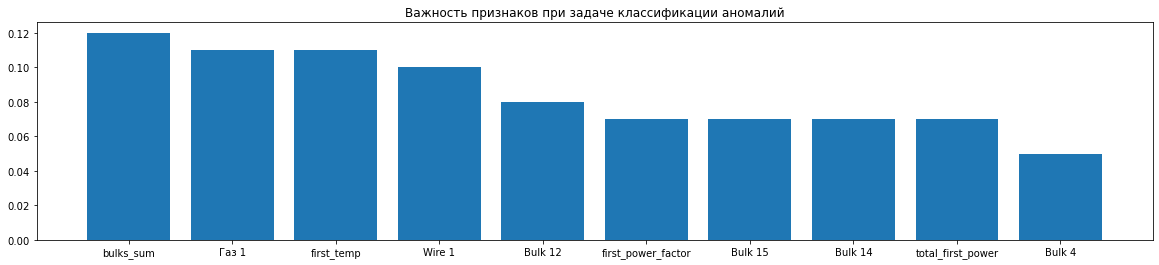

In [57]:
bag_class_data = pd.DataFrame(data=[round(float(i), 2) for i in rf_bag.feature_importances_],
                              index=x_train_full_bag.drop('class', axis=1).columns,
                             columns=['features'])

plt.figure(figsize=(20, 4))
           
plt.bar(x=bag_class_data.query('features != 0').sort_values(by='features', ascending=False).index[:10], 
       height=bag_class_data.query('features != 0').sort_values(by='features', ascending=False)['features'][:10])
plt.title('Важность признаков при задаче классификации аномалий')

Судя по ответу алгоритма, с выбивающимися значениями наиболее сильно коррелирукет совокупность добавок, и фактор первой температуры. (Но первая температура выступает наиболее важной и в задаче регрессии как на полном, так и на частичном датасете). 

Text(0.5, 1.0, 'Важность признаков при задаче регрессии')

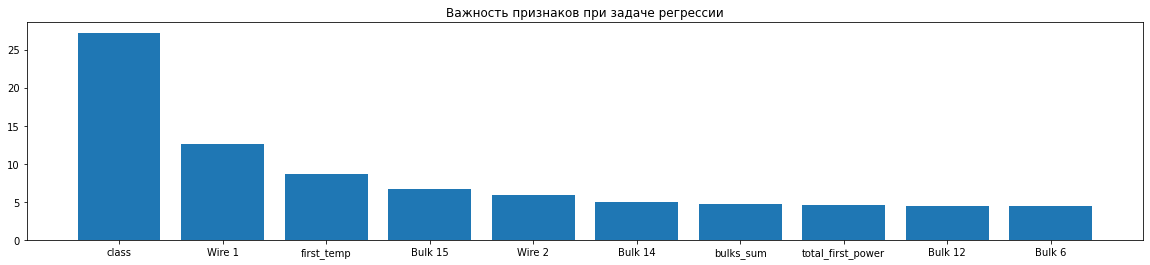

In [28]:
bag_regression_data = pd.DataFrame(data=[round(float(i), 2) for i in cat_bag2.feature_importances_],
                                  index=cat_bag2.feature_names_, columns=['features'])

plt.figure(figsize=(20, 4))

plt.bar(x=bag_regression_data.query('features != 0').sort_values(by='features', ascending=False).index[:10], 
       height=bag_regression_data.query('features != 0').sort_values(by='features', ascending=False)\
        ['features'][:10])

plt.title('Важность признаков при задаче регрессии')

Видим, что класс оказывается сильно влияющим на предсказние признаком. Это делает гипотезу о выигрышной эффектинвости бэггинга ещё более вероятной. 

<a id='3'> </a>
## Общий вывод

В ходе построения прототипа работающей системы с применением машинного обучения было выявлено, что наиболее сильно с финальной температурой связана комбинация признаков первой температуры, wire and bulk 1, фактора мощности и объема газа. Можно выдвинуть гипотезу, что регулируя эти параметры на производстве можно наиболее сильно влиять на финальную температуру. 

Однако, взаимосвязь признаков имеет не линейную структуру (корреляция с признаками попарно не значима), кроме того, важна кобминация и рассчет верного веса признака, а значит обойтись без применения машинного обучения математически невозможно. 

Наилучшим вариантом явлется композиция алгоритмов из двух шагов, где первая задача -- детекция потенциальных аномалий, а вторая -- прдсказание значения регрессии. Такой подход позволит объяснять более 50% изменения целевой переменной (при том, что предсказание всегда среднего позволяет объяснять в лучшем случае только 20%). Также, машинное обучение поможет предприятию минимизировать ошибку на 11 пнуктов. (В среднем алогритм ошибается на 5.9). При дообучении этот результат можно улучшить, что доказывают эксперименты с увелечением классов в обучабщем алгоритме.  

В ходе разведовательного анализа было выялено, что с августа по сентябрь логирование температуры, кроме первой, не производилось. Также был найден один сбой логирующей системы с отрицательным показателем мощности. (Вопрос в потенциальный зал, что это могло быть?)

Также важно, что на более большом промежтке собранных данных модель можно будет улучшить так, чтобы учитывать состояние изношенности оборудования. 

(Здесь мог бы быть занавес). 

# Отчетность для заказывающей стороны

**Качество:** текущая абсолютная ошибка: 16, абсолютная ошибка лучшей модели: 6 (улучшение точности определения финальной температуры +38%). 

#### **Обучение:**
Модель обучена на диапазоне данных о партиях от 3го мая до 6 августа. (Для обучения был предоставлен диапазон до 1го сентября, однако с 6го агвуста по 1е сентября данные пришлось исключить в связи с отствутсвием данных о наличии целевой переменной). 

**Проведенная предобработка:**

- Введены категориальные признаки для редких добавок: wires -- 3, 4, 6, 7, 8, 9, bulks -- 1, 2, 5, 7, 8, 9, 10, 11, 13, где 0 -- материал не был добавлен, а 1 -- материал был добавлен. 
- Исключена информация о добавке wire 5, тк с учетом исключения неверно зарегестрированных объектом данная проволока не примешивалась ни разу. 
- Рассчитаны метрик мощности, чтобы более полно учитывать данный признак: 
  - Полная мощность: $S$, единица измерения: ВА (Вольт Ампер) $\sqrt{Q^2 + P^2}$ \
  - Коэффициент мощности (Power Factor – PF):  $k$ | $cosФ$ ($cosФ=k=P/S$), единица измерения: безразмерная величина
- Исключены данные о промежуточных мощностях и температуре, чтобы приблизить максимально возможное сокращение итераций поиска оптимальной температуры
- Перед подачей на вход алгоритму признаки стандартизиируется к распределению со средним 0 и стандартным отклоненением 1, что позволяет нивелировать влияние разных по размеру величин. (Например, диапазон мощности без стандартизации от 0.03 до ~4, а добавок от 0 до 1850)
- Введен дополнительный признак -- class, где 1 -- значение, выбивающееся из среднего диапазона, а 0 -- значение из среднестатистического распределения

**Схема работы:**

Вначале модель обрабатывает данные присваивая им класс, где 0 -- значение среднестатистического класса, а 1 -- класса, чье значение последней температуры выйдет из среднего диапазона. После, объект с присвоенной меткой поступает на вход регрессору, который выдает оптимальное значение температуры. 

Такой подход позволяет не только корректировать значения температуры, но и детектировать потенциально "необычные" партии. Кроме того, модели интепретируемы (графики важности признаков приложены в п. 3), что позволяет понимать природу выданных ответов. 
